# MNIST - Ćwiczenie z CNN
Skoro widzieliśmy już wyniki modelu sztucznej sieci neuronowej na <a href='https://en.wikipedia.org/wiki/MNIST_database'>zbiorze danych MNIST</a>, pracujmy z tymi samymi danymi przy użyciu <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>konwolucyjnej sieci neuronowej</a> (CNN).
Pamiętaj, aby obejrzeć wykłady teoretyczne! Przyda się swobodna znajomość pojęć:
* warstwy konwolucyjne
* filtry/jądra
* warstwy pooling
* głębokość, krok i dopełnianie zerami

Zwróć uwagę, że w tym ćwiczeniu nie musimy spłaszczać danych MNIST, bo CNN oczekuje danych dwuwymiarowych.


## Wykonaj Standardowe Importy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Wczytaj Zbiór Danych MNIST
PyTorch udostępnia zbiory treningowe i testowe MNIST poprzez <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. Przy pierwszym wywołaniu zestawy zostaną pobrane na komputer do wskazanej ścieżki. Od tej pory torchvision będzie szukać lokalnej kopii, zanim rozpocznie ponowne pobieranie.

Wyjaśnienia dotyczące transformacji, rozmiarów partii oraz <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a> znajdziesz w poprzedniej sekcji.


In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Utwórz Loadery
Przy pracy z obrazami chcemy stosunkowo małych partii; rozmiar równy 4 wcale nie jest rzadkością.


In [5]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Zdefiniuj Model Konwolucyjny
W poprzedniej sekcji użyliśmy wyłącznie w pełni połączonych warstw: wejściowa miała 784 neurony (spłaszczone obrazy 28x28), warstwy ukryte liczyły 120 oraz 84 neurony, a warstwa wyjściowa reprezentowała 10 możliwych cyfr.

Tym razem zastosujemy dwie warstwy konwolucyjne i dwie warstwy pooling przed przekazaniem danych do w pełni połączonych warstw ukrytych oraz warstwy wyjściowej. Model idzie ścieżką CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.


<div class="alert alert-info"><strong>Przejdźmy krok po kroku przez planowane działania.</strong><br>

1. Rozszerzamy bazową klasę Module:
   
<tt><font color=black>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Konfigurujemy warstwy konwolucyjne za pomocą <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>Pierwsza warstwa ma jeden kanał wejściowy (skala szarości). Do ekstrakcji cech przypiszemy 6 kanałów wyjściowych. Ustawiamy rozmiar jądra na 3, aby utworzyć filtr 3x3, i krok na 1.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
Druga warstwa przyjmie 6 kanałów wejściowych i zwróci 16 kanałów wyjściowych.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Konfigurujemy warstwy w pełni połączone za pomocą <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br>Rozmiar wejścia (5x5x16) wynika z wpływu jąder na rozmiar obrazu. Filtr 3x3 zastosowany do obrazu 28x28 zostawia jednopi­xelowe brzegi ze wszystkich stron. W jednej warstwie rozmiar zmienia się z 28x28 na 26x26. Moglibyśmy użyć dopełniania zerami, ale ponieważ obraz MNIST jest głównie czarny na krawędziach, możemy bezpiecznie pominąć te piksele. Zastosujemy jądro dwa razy i dwukrotnie pooling, więc wynikowe wyjście będzie mieć 
$\;(((28-2)/2)-2)/2 = 5.5\;$ co zaokrągla się w dół do 5 pikseli na bok.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>
Poniżej znajdziesz dokładniejsze omówienie tego kroku.<br><br>

4. Definiujemy metodę forward.<br><br>Aktywacje można zastosować do warstw konwolucyjnych w jednej linijce dzięki <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a>, a pooling realizujemy przy użyciu <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>
<tt><font color=black>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
</font></tt>Spłaszczamy dane przed warstwami w pełni połączonymi:<br><tt><font color=black>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

<div class="alert alert-danger"><strong>Rozbijamy warstwy konwolucyjne na części składowe</strong> (ten kod służy wyłącznie do ilustracji).</div>


In [6]:
# Zdefiniuj warstwy
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [7]:
# Pobierz pierwszy rekord MNIST
for i, (X_train, y_train) in enumerate(train_data):
    break

In [8]:
# Utwórz tensor rzędu czwartego do przekazania modelowi
# (train_loader zrobi to automatycznie)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [9]:
# Wykonaj pierwszą konwolucję i aktywację
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [10]:
# Uruchom pierwszą warstwę pooling
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [11]:
# Wykonaj drugą konwolucję i aktywację
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [12]:
# Uruchom drugą warstwę pooling
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [13]:
# Spłaszcz dane
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


<div class="alert alert-danger"><strong>Tak przekazujemy wynik konwolucji do warstw w pełni połączonych.</strong></div>

Uruchommy teraz kod.


In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [7]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Po uwzględnieniu wyrazów bias dla każdej warstwy łączna liczba trenowanych parametrów wynosi:<br>

$$
\quadegin{split}(1	imes6	imes3	imes3)+6+(6	imes16	imes3	imes3)+16+(400	imes120)+120+(120	imes84)+84+(84	imes10)+10 &=\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}
$$


In [8]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [9]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## Zdefiniuj Funkcję Straty i Optymalizator


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Trenuj Model
Tym razem wprowadzimy dane bezpośrednio do modelu, bez wcześniejszego spłaszczania.


In [11]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Uruchom partie treningowe
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Zastosuj model
        y_pred = model(X_train)  # tutaj nie spłaszczamy X_train
        loss = criterion(y_pred, y_train)
 
        # Zlicz liczbę poprawnych predykcji
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Zaktualizuj parametry
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Wypisz wyniki pośrednie
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Uruchom partie testowe
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Zastosuj model
            y_val = model(X_test)

            # Zlicz liczbę poprawnych predykcji
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # wypisz upływ czasu            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04045902  accuracy:  78.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.07559647  accuracy:  85.825%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.37198648  accuracy:  88.722%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01985848  accuracy:  90.554%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00678484  accuracy:  91.677%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00181786  accuracy:  92.508%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.46452770  accuracy:  93.124%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.01664556  accuracy:  93.600%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00718968  accuracy:  94.022%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.02756804  accuracy:  94.318%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.02209568  accuracy:  97.700%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.05276305  accuracy:  97.792%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00120053  accuracy:  97.850%
epoch:  1  b

## Wykreśl Porównanie Straty i Dokładności


In [14]:
tt = [t.detach().numpy() for t in train_losses]
tl = [t.detach().numpy() for t in test_losses]

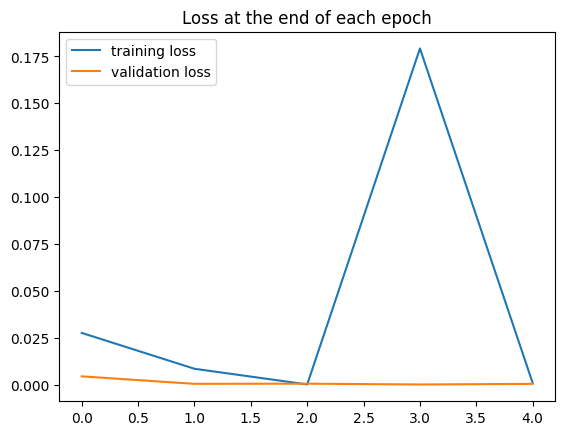

In [15]:
plt.plot(tt, label='training loss')
plt.plot(tl, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [16]:
test_losses

[tensor(0.0044),
 tensor(0.0004),
 tensor(0.0005),
 tensor(6.9462e-05),
 tensor(0.0004)]

Chociaż może występować lekkie przeuczenie danych treningowych, jest go znacznie mniej niż w modelu ANN.


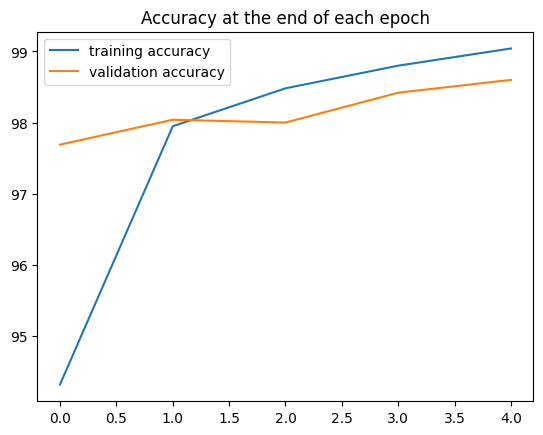

In [17]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Oceń Dane Testowe


In [23]:
# Pobierz dane za jednym razem, a nie partiami
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [24]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # tym razem nie spłaszczamy danych
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9848/10000 =  98.480%


Przypomnij sobie, że nasz model ANN o strukturze [784,120,84,10] osiągnął dokładność 97,25% po 10 epokach, zużywając 105 214 parametrów. Obecnie korzystamy z 60 074 parametrów.


## Wyświetl Macierz Pomyłek


In [19]:
# Wypisz wiersz wartości referencyjnych
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# Wypisz macierz pomyłek
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[   1    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [   0    0    0    0    0    1    0    0    0    0]
 [   0    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0    1    0]
 [   0    0    0    0    0    0    0    0    0    1]]


## Przeanalizuj Pomyłki
Możemy śledzić indeksy niepoprawnych przewidywań i wyciągać odpowiadające im obrazy oraz etykiety. Zrobimy to partiami, aby zaoszczędzić miejsce na ekranie.


In [20]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Wyświetl liczbę błędnych predykcji
len(misses)

0

In [21]:
# Wyświetl pierwszych 10 indeksów
misses[:10]

array([], dtype=float64)

In [22]:
# Przygotuj iterator do dostarczania partii wierszy
r = 12   # liczba elementów w wierszu
row = iter(np.array_split(misses,len(misses)//r+1))

Teraz, gdy wszystko jest gotowe, uruchamiaj wielokrotnie poniższą komórkę, aby obejrzeć wszystkie błędne przewidywania.<br>
Użyj <kbd>Ctrl+Enter</kbd>, aby pozostawać w tej komórce między kolejnymi uruchomieniami. Po przejrzeniu wszystkich pomyłek pojawi się wyjątek <tt>StopIteration</tt>.


In [23]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Index: []


RuntimeError: index_select(): Expected dtype int32 or int64 for index

## Przepuść Nowy Obraz Przez Model
Możemy też przekazać pojedynczy obraz do modelu, by uzyskać przewidywanie.
Wybierz liczbę od 0 do 9999, przypisz ją do zmiennej "x", a użyjemy jej do wyboru rekordu z testowego zbioru MNIST.


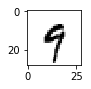

In [31]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [32]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9


## Świetna Robota!
